# Logistic Regression

이번 실습 시간에는 로지스틱 회귀에 대해 알아봅시다.

저저번주 이론 시간에, y의 값 자체를 추정하는 선형회귀와는 달리 로지스틱 회귀는 y의 값의 확률을 추정한다고 공부해보았습니다.

이번 시간에는 실제로 로지스틱 회귀 모형을 얻어내는 알고리즘을 구현해 볼 것입니다. 

## Sigmoid 함수

이론 시간에 배운 로지스틱 함수는 아래와 같았습니다.

\begin{equation*}
p(X) = \frac{e^{\beta_0+\beta_1X}}{1 + e^{\beta_0+\beta_1X}}
\end{equation*}

이번 시간에는 조금 특별한 형태의 로지스틱 함수인 <b>Sigmoid 함수</b>를 로지스틱 회귀에 사용할 것입니다.

Sigmoid 함수는 아래와 같습니다.

\begin{equation*}
p(X) = \frac{1}{1 + e^{-z}}
\end{equation*}

어떻게 생겼는지 그려 볼까요?

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

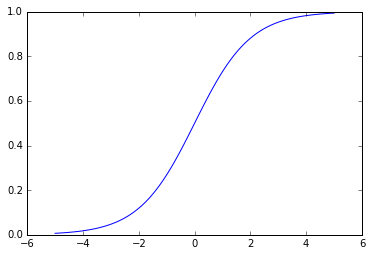

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

x = np.linspace(-5, 5, 100)  # x range -5 ~ 5
y = sigmoid(x)

plt.plot(x, y)
plt.show()

x의 범위를 조금 넓혀봅시다.

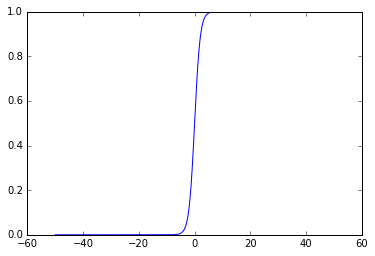

In [3]:
x = np.linspace(-50, 50, 500)
y = sigmoid(x)

plt.plot(x, y)
plt.show()

그래프를 보니 다음과 같은 사실을 알 수 있습니다.

<b>Sigmoid 함수는 z가 0보다 작을 때는 0에 가까이, 0보다 클때는 1에 가까이 가며, z가 0일 때는 0.5의 값을 갖는다.</b>

한 가지 생각해봅시다. x가 음수일때 0, 양수일때 1을 갖는 계단 함수와 비교하였을 때, sigmoid함수가 갖는 장점이 뭘까요?

## Gradient descent

### 목표

다시 sigmoid 함수를 쳐다봅시다.

\begin{equation*}
p(X) = \frac{1}{1 + e^{-z}}
\end{equation*}

우리는 저 $ z $를 가지고 로지스틱 회귀를 해야 합니다. 즉,

\begin{equation*}
z = w_0x_0 + w_1x_1 + w_2x_2 + ... + w_nx_n
\end{equation*}

을 대입할 것입니다. 여기서 $ \mathbf{w} = (w_0, w_1, w_2, ... w_n) $으로 weight vector를 의미하며 $ \mathbf{x} = (x_0, x_1, x_2, ..., x_n) $으로 feature vector를 의미합니다.

다시 쓰면,

\begin{equation*}
z = \mathbf{w^T}\mathbf{x}
\end{equation*}

이 됩니다. 위 식은 앞으로 자주 보게 될 식이니 익숙해지면 좋습니다.

즉 우리의 데이터셋을 가지고 가장 적절한 $ \mathbf{w} $를 찾는 것이 우리의 목표입니다.

<b>가장 적절한</b> $ \mathbf{w} $은 무엇일까요? 바로 우리의 모델이 예측한 값과 실제 값이 가장 비슷하도록 하는 $ \mathbf{w} $입니다.

다시 말해 예측 값과 실제 값 사이의 <b>error가 가장 작도록</b> 하는 $ \mathbf{w} $를 말합니다.

### 방법

이변수 함수 $ f(x, y) $의 gradient는 다음과 같이 쓸 수 있습니다.

\begin{equation*}
\nabla f(x, y) = (\begin{array}{c} \frac{\partial f(x, y)}{\partial x} \\ \frac{\partial f(x, y)}{\partial y} \end{array})
\end{equation*}

이 벡터의 방향은 (x, y)에서 스칼라값 f(x, y)가 가장 빨리 증가하는 방향이며, 180도 반대 방향은 가장 빨리 감소하는 방향입니다.

이제 x와 y를 $ \mathbf{w} $로 생각하고, $ f(\mathbf{w}) $의 값이 error를 나타낸다고 생각합시다.

임의의 점 $ \mathbf{w'} $에서 출발하여, 항상 $ f(\mathbf{w'}) $의 값이 가장 빨리 감소하는 방향, 즉 error가 가장 빨리 감소하는 방향으로 한 발짝씩 이동하다보면, 언젠가는 최솟값에 도달할 수 있을까요?

이러한 optimization 알고리즘을 Gradient Descent 알고리즘이라고 합니다. 즉, 일정한 상수 $ \alpha $를 설정하고,

\begin{equation*}
\mathbf{w} := \mathbf{w} - \alpha\nabla_w f(\mathbf{w})
\end{equation*}

를 반복하여 수행하다 보면 error를 최소화하는 지점에 도달할 수 있을 것이라는 아이디어입니다.

실제로 코딩을 해봅시다. 간단한 데이터셋을 불러오는 함수 <b>loadDataSet()</b>을 작성합시다.

In [4]:
def loadDataSet():
    dataMat = []
    labelMat = []
    
    with open("./datasets/chapter5_testset.txt", 'r') as f:
        for line in f.readlines():
            tokens = line.strip().split("\t")
            dataMat.append([1.0, float(tokens[0]), float(tokens[1])]) # prepended 1.0 to represent biases
            labelMat.append(int(tokens[2]))
    
    return np.array(dataMat).T, np.array(labelMat)

어떻게 생긴 데이터셋일까요?

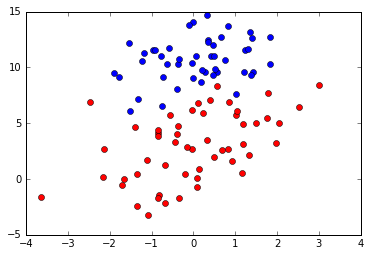

In [5]:
def plotDataSet(dataMat, labelMat):
    dataMatX0 = dataMat[1, labelMat == 0]
    dataMatY0 = dataMat[2, labelMat == 0]
    
    dataMatX1 = dataMat[1, labelMat == 1]
    dataMatY1 = dataMat[2, labelMat == 1]
    
    plt.plot(dataMatX0, dataMatY0, 'bo')  # blue dots
    plt.plot(dataMatX1, dataMatY1, 'ro')  # red dots
    plt.show()

dataMat, labelMat = loadDataSet()
plotDataSet(dataMat, labelMat)

로지스틱 회귀 모델을 위의 데이터로 train 하여 볼 것입니다.

Pseudocode는 아래와 같습니다.

### Pseudocode

모든 weight들을 1로 초기화한다.

R회 반복:

    현재 weight 값에 대한 gradient를 계산한다.

    weight를 업데이트한다. (w := w - alpha * gradient)
        
weight vector를 return한다.



이제 직접 코딩해봅시다.

In [6]:
def gradientDescent(x, y, alpha=0.001, maxIteration=500, printStep=100):
    rowCount, colCount = x.shape
    
    weights = np.ones((rowCount, 1))  # initialize all weights to 1
    
    for k in range(maxIteration):
        # compute gradient
        z = weights.T.dot(x)
        yHat = sigmoid(z)
        gradient = x.dot((-2 * (y - yHat) * yHat * (1 - yHat)).T)  # Think about this line
        # update weights
        weights = weights - alpha * gradient
        
        if k % printStep == 0:
            error = np.mean(np.square(y-yHat))
            print("Iteration %d: error %.2f" % (k, error))
    
    return weights

dataMat, labelMat = loadDataSet()
weights = gradientDescent(dataMat, labelMat)

print(weights)

Iteration 0: error 0.55
Iteration 100: error 0.52
Iteration 200: error 0.10
Iteration 300: error 0.09
Iteration 400: error 0.08
[[ 2.43985932]
 [ 0.32473241]
 [-0.37937044]]


이 weight이 우리의 데이터셋을 잘 분류해주는지 확인해봅시다.

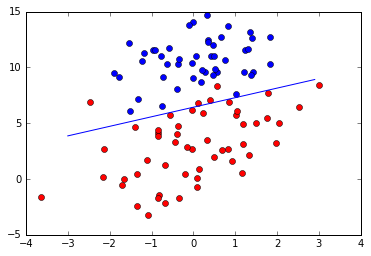

In [7]:
def plotBestFit(w):
    dataMat, labelMat = loadDataSet()
    dataArr = np.array(dataMat)
    
    dataMatX0 = dataMat[1, labelMat == 0]
    dataMatY0 = dataMat[2, labelMat == 0]
    dataMatX1 = dataMat[1, labelMat == 1]
    dataMatY1 = dataMat[2, labelMat == 1]
    
    plt.plot(dataMatX0, dataMatY0, 'bo')  # blue dots
    plt.plot(dataMatX1, dataMatY1, 'ro')  # red dots
    
    # draw line
    x = np.arange(-3.0, 3.0, 0.1)
    y = (-weights[0] - weights[1] * x) / weights[2] # probability == 0.5 on this line
    plt.plot(x, y)
    plt.show()

plotBestFit(weights)

## Stochastic Gradient Descent

위의 예에서는 데이터셋 안의 모든 데이터에 대해서 한번에 gradient를 계산하여 합쳤습니다. 이러한 방법을 <b>batch</b> gradient descent라고 합니다.

하지만 데이터셋의 크기가 매우 커지면 위의 방법을 iteration 한 번 한 번이 매우 느려지게 되어 비효율적입니다.

저렇게 전체 데이터셋을 한번에 고려하지 말고 각각의 반복에서 데이터셋의 일부만을 뽑아서 학습시킬 수는 없을까요?

이러한 아이디어에서 출발한 알고리즘을 <b>stochastic</b> gradient descent라고 합니다.

Stochastic gradient descent의 pseudocode는 아래와 같습니다.

### Pseudocode

모든 weight들을 1로 초기화한다.

데이터셋의 일부를 뽑아 만든 각각의 작은 데이터셋들에 대해서:

    각각의 데이터셋에서 gradient를 계산한다.
    
    weight를 업데이트한다. (w := w - alpha * gradient)

weight vector를 return한다.

직접 코딩해봅시다. 작성할 함수 <b>stochasticGradientDescent()</b>는 매 반복마다 한 개의 데이터를 뽑아 error의 gradient를 구하여 weight를 update합니다.

[[ 5.94827494]
 [ 0.7000902 ]
 [-0.86038205]]


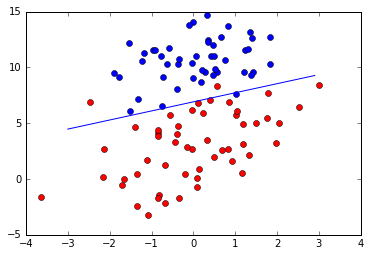

In [8]:
def stochasticGradientDescent0(x, y, alpha=0.01, maxIteration=500):
    rowCount, colCount = x.shape
    
    weights = np.ones((rowCount, 1))  # initialize all weights to 1
    
    for _ in range(maxIteration):
        for i in range(colCount):  # each column represents a data
            data = x[:, i].reshape((rowCount, 1))  # make data a column vector

            # compute gradient
            z = weights.T.dot(data)
            yHat = sigmoid(z)
            gradient = -2 *  (y[i] - yHat) * yHat * (1 - yHat) * data  # Think about this line
            # update weights
            weights = weights - alpha * gradient
    
    return weights

dataMat, labelMat = loadDataSet()
weights = stochasticGradientDescent0(dataMat, labelMat)
print(weights)

plotBestFit(weights)

위의 함수를 maxIteration 값을 바꿔가면서 실행시켜서 어떤 결과가 나오는지 확인해보세요. (maxIteration = 10, 100, 1000, 1000)

Weight값들이 언제 적절한 값에 수렴하는 것일까요? 확인해보면 아래의 그림과 같습니다.

<img src="./img/5_1.png"></img>

꽤나 많은 반복 후에야 수렴한다는 것을 알 수 있습니다.

이를 개선하기 위해서 우리의 <b>stochasticGradientDescent0</b> 함수에 두 가지 수정을 가한 <b>stochasticGradientDescent1</b>를 작성합시다.

1. 첫째로 alpha의 값을 시간이 지남에 따라 점점 작게 만들 것입니다.

2. 두 번째는 데이터셋에서 데이터를 순서대로 고르는 것이 아니라, 무작위로 고를 것입니다.

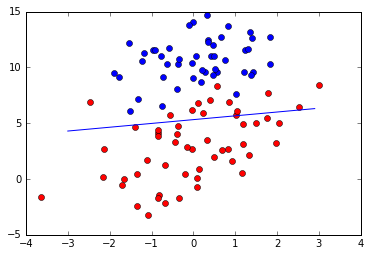

In [9]:
def stochasticGradientDescent1(x, y, alpha=0.01, maxIteration=100):
    rowCount, colCount = x.shape
    
    weights = np.ones((rowCount, 1))  # initialize all weights to 1
    
    for j in range(maxIteration):
        dataIndex = list(range(colCount))
        for i in range(colCount):                     # each column represents a data
            # adjust alpha
            alpha = 4 / (1.0 + j + i) + 0.01
            # pick random data
            randIndex = int(np.random.uniform(0, len(dataIndex)))
            data = x[:, randIndex].reshape((rowCount, 1))
            # compute gradient
            z = weights.T.dot(data)
            yHat = sigmoid(z)
            gradient = -2 *  (y[randIndex] - yHat) * yHat * (1 - yHat) * data  # Think about this line
            # update weights
            weights = weights - alpha * gradient
            # remove used index from index list
            del(dataIndex[randIndex])
    
    return weights

dataMat, labelMat = loadDataSet()
weights = stochasticGradientDescent1(dataMat, labelMat, maxIteration=50)

plotBestFit(weights)

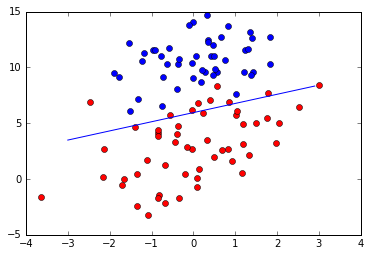

In [10]:
dataMat, labelMat = loadDataSet()
weights = stochasticGradientDescent0(dataMat, labelMat, maxIteration=50)

plotBestFit(weights)

## 실습 : Parkinson's disease

<a href="./datasets/parkinson.txt">데이터셋 다운로드</a>

이 데이터셋은 총 31명의 사람들의 목소리를 여러번 녹음하여, 그로부터 아래와 같은 feature들을 추출한 데이터셋입니다.

(총 22개의 feature)

(parkinson's disease 환자 23명, 건강한 사람 8명)

1. MDVP:Fo(Hz) - Average vocal fundamental frequency 
2. MDVP:Fhi(Hz) - Maximum vocal fundamental frequency 
3. MDVP:Flo(Hz) - Minimum vocal fundamental frequency 
4. MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several measures of variation in fundamental frequency 
5. MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude 
6. NHR,HNR - Two measures of ratio of noise to tonal components in the voice 
7. RPDE,D2 - Two nonlinear dynamical complexity measures 
8. DFA - Signal fractal scaling exponent 
9. spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation 
10. status - Health status of the subject (one) - Parkinson's, (zero) - healthy 

우리의 목표는 이 목소리의 feature들을 이용하여 건강한 사람의 목소리가 무엇인지 가려내는 것입니다.

1. 로지스틱 회귀 모델로부터 class를 분류하는 함수를 작성해 봅시다.

2. 이번 주 이론 시간에 배운 Cross-validation을 이용하여, 모델의 정확도를 계산해 봅시다. (10-fold CV를 이용하세요.)